In [1]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
import os

# Check current directory
print("Current directory:", os.getcwd())

# Change to the desired directory
os.chdir(r'C:\Users\PC\ProjetGoMyCode')

# Verify that the directory has changed
print("New working directory:", os.getcwd())


Current directory: C:\Users\PC\Downloads
New working directory: C:\Users\PC\ProjetGoMyCode


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
POS_PATH = os.path.join ('data', 'positive')
NEG_PATH = os.path.join ('data', 'negative')
ANC_PATH = os.path.join ('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import uuid

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    #cut down frame to 250x250 pixels
    frame = frame[120:120+250,200:200+250, : ]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname= os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname= os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
        
    #show image 
    cv2.imshow('Image Collection', frame)
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
   
        
# Release the webcamq
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [5]:
##Form a dataset from our photos
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
print(dir_test.next())

b'data\\anchor\\8448cc6e-7512-11ef-8a3a-10653073972e.jpg'


In [8]:
#processing : scaling and resizing the data

def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image 
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [10]:
samples = data.as_numpy_iterator()

In [11]:
example = samples.next()

In [12]:
example

(b'data\\anchor\\7565ee26-7512-11ef-81ba-10653073972e.jpg',
 b'data\\positive\\d358ee9e-7512-11ef-a126-10653073972e.jpg',
 1.0)

In [9]:
#Create lablelles dataset ( 0 and 1)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
#Build Train and Test partition

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


In [14]:
res = preprocess_twin(*example)


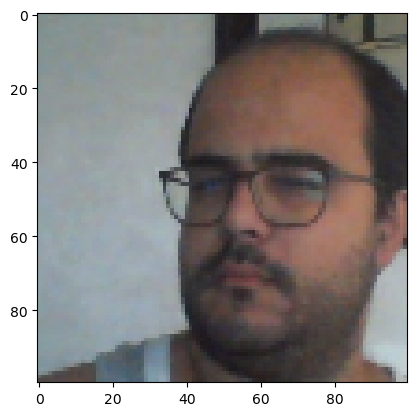

In [22]:
plt.imshow(res[1])

In [15]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [16]:
samples = data.as_numpy_iterator()
samples.next()

(array([[[0.50465685, 0.5977941 , 0.5654412 ],
         [0.5154412 , 0.59583336, 0.56936276],
         [0.5259804 , 0.58455884, 0.5647059 ],
         ...,
         [0.6605392 , 0.51740193, 0.43063724],
         [0.6612745 , 0.51004905, 0.4343137 ],
         [0.6637255 , 0.5029412 , 0.42303923]],
 
        [[0.51666665, 0.5872549 , 0.56397057],
         [0.5264706 , 0.59117645, 0.5686275 ],
         [0.52892154, 0.59068626, 0.56960785],
         ...,
         [0.6482843 , 0.50514704, 0.43063724],
         [0.6490196 , 0.50808823, 0.4245098 ],
         [0.6487745 , 0.5095588 , 0.40637255]],
 
        [[0.52843136, 0.5872549 , 0.5735294 ],
         [0.52867645, 0.5889706 , 0.57303923],
         [0.52843136, 0.595098  , 0.5715686 ],
         ...,
         [0.63210785, 0.5029412 , 0.4240196 ],
         [0.6272059 , 0.50465685, 0.42230392],
         [0.6129902 , 0.4970588 , 0.39044118]],
 
        ...,
 
        [[0.33431372, 0.44411764, 0.53088236],
         [0.32254902, 0.44485295, 0.51470

In [17]:
samp = samples.next()

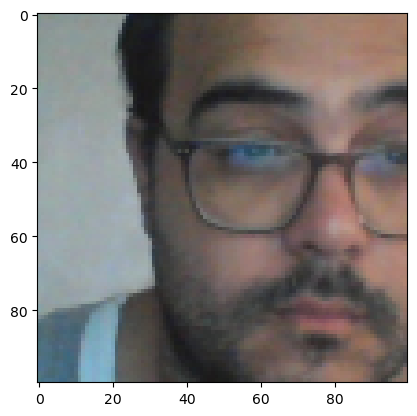

In [18]:
plt.imshow(samp[0])

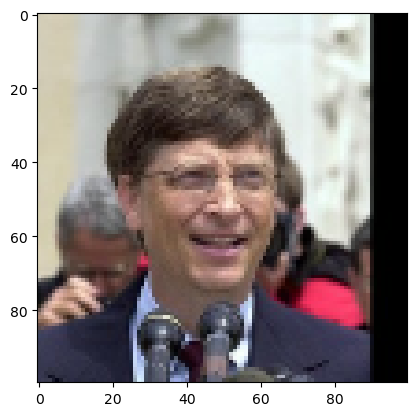

In [19]:
plt.imshow(samp[1])

In [20]:
samp[2]

0.0

In [21]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


In [22]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Make embedding model

In [23]:
inp = Input(shape=(100,100,3), name='input_image')

In [24]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [25]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [26]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [27]:
m2

<KerasTensor shape=(None, 20, 20, 128), dtype=float32, sparse=False, name=keras_tensor_3>

In [28]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [29]:
m3

<KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, name=keras_tensor_5>

In [30]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [31]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
 def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [34]:
embedding = make_embedding()

In [35]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [37]:
l1 = L1Dist()

# Make Siamese Model

In [38]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [39]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [40]:
siamese_layer = L1Dist()

In [41]:
distances = siamese_layer(inp_embedding, val_embedding)

In [42]:
classifier = Dense(1, activation='sigmoid')(distances)

In [43]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [44]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [45]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [47]:
siamese_model = make_siamese_model()

In [48]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Loss function and Optimizer

In [49]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [50]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# Checkpoints

In [51]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Train step function

In [52]:
test_batch = train_data.as_numpy_iterator()

In [53]:
batch_1 = test_batch.next()

In [54]:
len(batch_1[2])

16

In [55]:
X= batch_1[:2]

In [56]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [57]:
Y= batch_1[2]

In [58]:
Y

array([1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [59]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    tf.print("Loss:", loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [60]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [61]:
EPOCHS = 10

In [62]:
train(train_data, EPOCHS)


 Epoch 1/10
Loss: 0.692303419
 1/27 ━━━━━━━━━━━━━━━━━━━━ 2:48 6s/stepLoss: 0.67253226
 2/27 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/stepLoss: 0.628661
 3/27 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/stepLoss: 0.633286536
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/stepLoss: 0.467960715
 5/27 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/stepLoss: 0.669189751
 6/27 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/stepLoss: 0.503489435
 7/27 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/stepLoss: 0.452334464
 8/27 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/stepLoss: 0.545512199
 9/27 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/stepLoss: 0.335964739
10/27 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/stepLoss: 0.605258942
11/27 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/stepLoss: 0.384011209
12/27 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step Loss: 0.431703031
13/27 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/stepLoss: 0.317895919
14/27 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/stepLoss: 0.339086443
15/27 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/stepLoss: 0.421957314
16/27 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/stepLoss: 0.328225493
17/27 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/stepLoss: 0.192486435
18/27 ━━━

10/27 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/stepLoss: 0.0519590974
11/27 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/stepLoss: 0.105175517
12/27 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/stepLoss: 0.0419910662
13/27 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/stepLoss: 0.116823204
14/27 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step Loss: 0.138075739
15/27 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/stepLoss: 0.0621656515
16/27 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/stepLoss: 0.103576213
17/27 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/stepLoss: 0.144109011
18/27 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/stepLoss: 0.0469839536
19/27 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/stepLoss: 0.0403287932
20/27 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/stepLoss: 0.0815202221
21/27 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/stepLoss: 0.385544837
22/27 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/stepLoss: 0.0929435119
23/27 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/stepLoss: 0.082771033
24/27 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/stepLoss: 0.0999185443
25/27 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step Loss: 0.185526
26/27 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepLoss: 0.199586391
27/27 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step

19/27 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/stepLoss: 0.0232255794
20/27 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/stepLoss: 0.0820423812
21/27 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/stepLoss: 0.0682952702
22/27 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/stepLoss: 0.0501018353
23/27 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/stepLoss: 0.0725900307
24/27 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/stepLoss: 0.169878453
25/27 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step Loss: 0.0180776771
26/27 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/stepLoss: 0.0615260489
27/27 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step

 Epoch 8/10
Loss: 0.071672976
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/stepLoss: 0.0821041539
 2/27 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/stepLoss: 0.0442272425
 3/27 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/stepLoss: 0.0981369615
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/stepLoss: 0.00977291
 5/27 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/stepLoss: 0.0322774313
 6/27 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/stepLoss: 0.0289893448
 7/27 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/stepLoss: 0.0147669241
 8/27 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/stepLoss: 0.00559180696
 9/27 ━━━━━━

# Evalute our model

In [63]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [64]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [65]:
y_true

array([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [66]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[8.9798814e-05],
       [9.9679273e-01],
       [7.2486910e-05],
       [3.4903064e-07],
       [9.9988407e-01],
       [1.8379018e-05],
       [1.9032166e-05],
       [9.7919590e-05],
       [7.6991779e-01],
       [9.6332330e-01],
       [9.9997878e-01],
       [9.6953434e-01],
       [9.8546058e-01],
       [8.7176079e-01],
       [9.9408776e-01],
       [9.9976087e-01]], dtype=float32)

In [68]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [69]:
y_true[3]

0.0

# Metrics


In [70]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [71]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

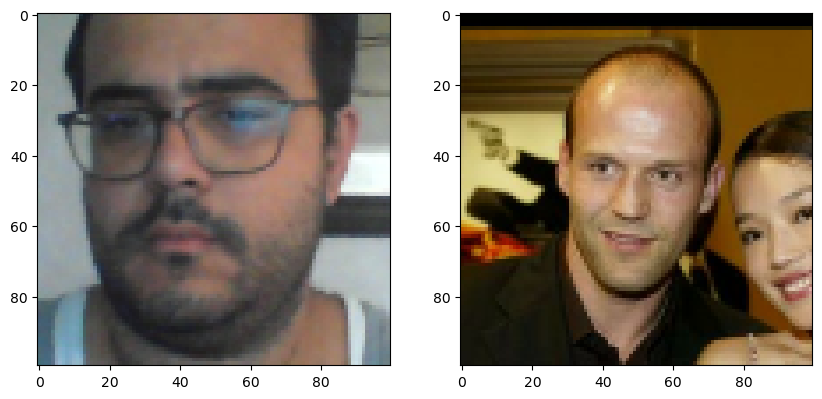

In [72]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

# Save model

In [73]:
siamese_model.save('siamesemodel.h5')

In [74]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [75]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[8.9798814e-05],
       [9.9679273e-01],
       [7.2486910e-05],
       [3.4903064e-07],
       [9.9988407e-01],
       [1.8379018e-05],
       [1.9032166e-05],
       [9.7919590e-05],
       [7.6991779e-01],
       [9.6332330e-01],
       [9.9997878e-01],
       [9.6953434e-01],
       [9.8546058e-01],
       [8.7176079e-01],
       [9.9408776e-01],
       [9.9976087e-01]], dtype=float32)

In [76]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Real time verification

In [132]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# OpenCV Real Time Verification

In [1]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [123]:
np.sum(np.squeeze(results) > 0.5)

21